# exp004_train
[Notion](https://www.notion.so/exp004-5a9b8ebe2c1a45e39b567acbc3b86583?pvs=4)  
segmentationモデルの学習

Copy from: 
None

In [1]:
import os
import random
import sys
import warnings
warnings.filterwarnings('ignore')
from typing import Tuple

import albumentations as A
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.cuda.amp as amp
from sklearn.model_selection import GroupKFold
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# リポジトリtopに移動
while os.path.basename(os.getcwd()) != 'rsna-2023':
    os.chdir('../')
    if os.getcwd() == '/':
        raise Exception('Could not find project root directory.')

from src.segmentation.dataset import TrainDataset, save_df
from src.image_processing import windowing
from src.logger import get_logger
from src.loss import BCEDiceLoss, DiceCoef
from src.segmentation.model import unetv2, unetv2_amp, lock_model_encoder_weight
from src.segmentation.trainer import fit_model
from src.samplar import MultilabelBalancedRandomSampler

# Config

In [2]:
class CFG:
    exp_name = 'exp_004'
    # model config
    backbone = 'efficientnet-b3'
    n_ch = 1
    n_class = 4 # 学習時は腎臓の左右を区別しないので、5->4
    # hyper params
    init_lr = 1e-3
    min_lr = 1e-6
    weight_decay = 1e-4
    image_size = (512, 512)
    batch_size = 32
    amp = True
    n_epoch = 20
    iteration_per_epoch = 200
    pretrain = True
    freeze_epochs = 1
    noaug_epochs = 1
    # fold config
    n_fold = 6
    include_evaluation = False
    train_folds = 1
    # path
    image_dir = "data/dataset001/train_images"
    mask_dir = "data/dataset001/segmentations"
    model_save_dir = "outputs"
    # other config
    seed = 42
    num_workers = 0
    num_gpus = 2
    progress_bar = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# create output dir
os.makedirs(os.path.join(CFG.model_save_dir, CFG.exp_name), exist_ok=True)

# get label correspondences
organ_index_dict_inv = {
    0: 'liver',
    1: 'spleen',
    2: 'kidney',
    3: 'bowel'
}
organ_index_dict = {v: k for k, v in organ_index_dict_inv.items()}

# seed setting
def seed_everything(seed=CFG.seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

# logger setting
logger = get_logger(CFG)

# load dataframe
df_train = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/train.csv')
df_train_image_level = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/image_level_labels.csv')
df_train_serirs_meta = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')
df_seg_info_image = pd.read_csv("data/dataset001/seg_info_image.csv")
df_seg_info_series = pd.read_csv("data/dataset001/seg_info_series.csv")

# Dataset

In [4]:
def get_training_dataframe():
    """データセットのDataFrameを作成する.
    データセットによって内容を書き換える必要あり.
    """
    # df_seg_info_imageをベースに、学習用データフレームを構築.
    # df_seg_info_imageは、exp002で作成されるcsvファイル.
    image_paths = []
    mask_paths = []
    for i in range(len(df_seg_info_image)):
        sr = df_seg_info_image.iloc[i]
        any = sr["any"]
        pid, sid = sr["patient_id"], sr["series_id"]
        image_id = sr["image_id"]
        image_path = os.path.join(CFG.image_dir, str(pid), str(sid), f"{image_id}.npy")
        image_paths.append(image_path)
        if any:
            mask_path = os.path.join(CFG.mask_dir, str(sid), f"{image_id}.npz")
            mask_paths.append(mask_path)
        else:
            mask_path = None
            mask_paths.append(mask_path)
    # 画像データのDataFrameを作成
    df = pd.DataFrame({
            'image_path': image_paths, 
            'mask_path': mask_paths
            })
    
    # df_seg_info_imageとdfを横方向に結合.
    df = pd.concat([df_seg_info_image, df], axis=1)

    # 腎臓は左右を結合したラベルを作成
    df['kidney'] = df.apply(lambda x: min(1, x['kidney_left'] + x['kidney_right']), axis=1)

    # サンプラーに必要なため、anyの反転ラベルを作成
    df['any_inv'] = df['any'].apply(lambda x: 1 - x)


    # 画像データのDataFrameに、foldの情報を追加.
    # 正しいデータ分割のため、患者IDごとに分ける.
    df['fold'] = -1
    gkf = GroupKFold(n_splits=CFG.n_fold)
    for fold, (train_idx, val_idx) in enumerate(gkf.split(df, groups=df['patient_id'])):
        df.loc[val_idx, 'fold'] = fold
    
    return df

In [5]:
df = get_training_dataframe()
save_df(df, CFG)

In [6]:
df.head()

,Unnamed: 0,liver,spleen,kidney_left,kidney_right,bowel,any,patient_id,series_id,image_id,image_index,image_path,mask_path,kidney,any_inv,fold
0,0,0,0,0,0,1,1,54722,10000,257,0,data/dataset001/train_images/54722/10000/257.npy,data/dataset001/segmentations/10000/257.npz,0,0,4
1,1,0,0,0,0,1,1,54722,10000,258,1,data/dataset001/train_images/54722/10000/258.npy,data/dataset001/segmentations/10000/258.npz,0,0,4
2,2,0,0,0,0,1,1,54722,10000,259,2,data/dataset001/train_images/54722/10000/259.npy,data/dataset001/segmentations/10000/259.npz,0,0,4
3,3,0,0,0,0,1,1,54722,10000,260,3,data/dataset001/train_images/54722/10000/260.npy,data/dataset001/segmentations/10000/260.npz,0,0,4
4,4,0,0,0,0,1,1,54722,10000,261,4,data/dataset001/train_images/54722/10000/261.npy,data/dataset001/segmentations/10000/261.npz,0,0,4


In [7]:
def apply_preprocess(image: np.ndarray, mask: np.ndarray)-> Tuple[np.ndarray, np.ndarray]:
    """データ前処理. カスタマイズして使用.
    Args:
        image (numpy.ndarray): HU値のCT画像.
        mask (numpy.ndarray): channel lastのマスク画像.
    Returns:
        image (numpy.ndarray): windowing及び0~1に正規化.
        mask (numpy.ndarray): channel lastのマスク画像.
    """
    # 0~1に正規化
    image = windowing(image, wl=0, ww=400, mode="float32")
    return image, mask

def get_aug():
    """データ拡張. カスタマイズして使用.
    Note:
        画像のResizeはDataset側で行うので、この関数に入れる必要はない.
    """
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5
            ),
            A.OneOf(
                [
                    A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0),
                ],
                p=0.25,
            ),
            A.CoarseDropout(
                max_holes=8,
                max_height=CFG.image_size[0] // 20,
                max_width=CFG.image_size[1] // 20,
                min_holes=5,
                fill_value=0,
                mask_fill_value=0,
                p=0.5,
            ),
        ],
        p=1.0,
    )

In [8]:
ds = TrainDataset(CFG, df, preprocess=apply_preprocess, tfms=get_aug())

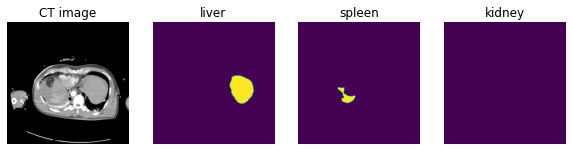

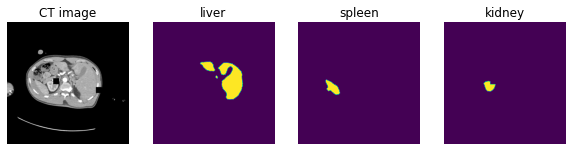

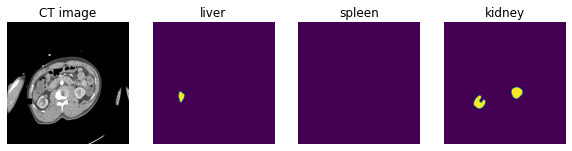

In [9]:
for i in range(3):
    img, mask = ds[100+i*50]
    # img, maskを並べて表示
    fig, ax = plt.subplots(1, 4, figsize=(10, 5))
    ax[0].imshow(img.numpy().transpose(1,2,0), cmap='gray')
    ax[0].set_title("CT image")
    for j in range(3):
        ax[1+j].imshow(mask.numpy()[j])
        ax[1+j].set_title(organ_index_dict_inv[j])

    for j in range(4):
        ax[j].grid(False)
        ax[j].axis(False)

In [10]:
result_dict = {}

for fold in range(CFG.train_folds):
    logger.info(f"Fitting on Fold {fold+1}")
    # Dataset
    if CFG.include_evaluation: # evaluation用のデータを最後のfoldに含める場合
        df_train = df[(df["fold"] != fold) & (df["fold"] != CFG.n_fold-1)].reset_index(drop=True)
        df_valid = df[df["fold"] == fold].reset_index(drop=True)
    else:
        df_train = df[df["fold"] != fold].reset_index(drop=True)
        df_valid = df[df["fold"] == fold].reset_index(drop=True)
    train_data = TrainDataset(
        CFG, df_train, preprocess=apply_preprocess, tfms=get_aug()
    )
    valid_data = TrainDataset(CFG, df_valid, preprocess=apply_preprocess, tfms=None)

    # Sampler
    # 各クラスを均等に学習することで、効率的に学習する.
    train_sampler = MultilabelBalancedRandomSampler(
        CFG,
        df_train[['liver', 'spleen', 'kidney', 'bowel', 'any_inv']].to_numpy(),
        class_choice="random",
        num_iteration=CFG.iteration_per_epoch
    )
    valid_sampler = MultilabelBalancedRandomSampler(
        CFG,
        df_valid[['liver', 'spleen', 'kidney', 'bowel', 'any_inv']].to_numpy(),
        class_choice="random",
        num_iteration=CFG.iteration_per_epoch//5
    )

    # Data Loader
    train_iterator = DataLoader(
        train_data,
        sampler=train_sampler,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        pin_memory=True,
    )
    valid_iterator = DataLoader(
        valid_data,
        sampler=valid_sampler,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        pin_memory=True,
    )

    # noaug_iterator
    train_noaug_data = TrainDataset(
        CFG, df_train, preprocess=apply_preprocess, tfms=None
    )
    train_noaug_iterator = DataLoader(
        train_noaug_data,
        sampler=train_sampler,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        pin_memory=True,
    )

    if CFG.amp:
        model = unetv2_amp(CFG).to(CFG.device)
        scaler = amp.GradScaler()
    else:
        model = unetv2(CFG).to(CFG.device)
        scaler = None
    if CFG.num_gpus > 1:
        model = nn.DataParallel(model)

    model_name = f"{CFG.exp_name}_f{fold}"

    if CFG.freeze_epochs:
        logger.info("+-+-+-+-+-+-+-+-+")
        logger.info("pretrain mode")
        logger.info("+-+-+-+-+-+-+-+-+")

        loss_criterion = BCEDiceLoss()
        opt = AdamW(model.parameters(), lr=CFG.init_lr)
        scheduler = None

        model = lock_model_encoder_weight(model, mode="lock")

        _ = fit_model(
            CFG,
            model,
            model_name,
            train_iterator,
            train_noaug_iterator,
            valid_iterator,
            opt,
            loss_criterion,
            True,
            scaler,
            logger,
            scheduler,
            organ_index_dict_inv
        )

    logger.info("@*@*@*@*@*@*@*@*@")
    logger.info("fulltrain mode")
    logger.info("@*@*@*@*@*@*@*@*@")

    loss_criterion = BCEDiceLoss()
    opt = AdamW(model.parameters(), lr=CFG.init_lr, weight_decay=CFG.weight_decay)
    scheduler = CosineAnnealingLR(opt, CFG.n_epoch, eta_min=CFG.min_lr)

    model = lock_model_encoder_weight(model, mode="unlock")
    
    tr_loss, val_loss, val_dice, val_dice_each_cls = fit_model(
        CFG,
        model,
        model_name,
        train_iterator,
        train_noaug_iterator,
        valid_iterator,
        opt,
        loss_criterion,
        False,
        scaler,
        logger,
        scheduler,
        organ_index_dict_inv
    )

    result = {
        "tr_loss": tr_loss, 
        "val_loss": val_loss, 
        "val_dice": val_dice, 
        "val_dice_each_cls": val_dice_each_cls
    }
    result_dict[model_name] = result

2023-08-11 21:12:45,181 INFO: Fitting on Fold 1
2023-08-11 21:12:47,633 INFO: +-+-+-+-+-+-+-+-+
2023-08-11 21:12:47,634 INFO: pretrain mode
2023-08-11 21:12:47,635 INFO: +-+-+-+-+-+-+-+-+
Validation loss: 0.19626:  11%|█         | 40/367 [00:23<03:10,  1.71it/s]
2023-08-11 21:17:54,505 INFO: Epoch: 01 | Epoch Time: 5m 7s
2023-08-11 21:17:54,505 INFO: lr:0.0010000
2023-08-11 21:17:54,505 INFO: Train Loss: 0.027
2023-08-11 21:17:54,506 INFO: Val. Loss: 0.022 | Val. Dice Score : 0.586,
2023-08-11 21:17:54,506 INFO: -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
2023-08-11 21:17:54,506 INFO: liver Dice Score : 0.679
2023-08-11 21:17:54,506 INFO: spleen Dice Score : 0.340
2023-08-11 21:17:54,506 INFO: kidney Dice Score : 0.720
2023-08-11 21:17:54,506 INFO: bowel Dice Score : 0.604
2023-08-11 21:17:54,507 INFO: @*@*@*@*@*@*@*@*@
2023-08-11 21:17:54,507 INFO: fulltrain mode
2023-08-11 21:17:54,507 INFO: @*@*@*@*@*@*@*@*@
Validation loss: 0.17205:  11%|█         | 40/367 [00:22<03:05,  1.76it/s]
2023-08-11 21

# Validation

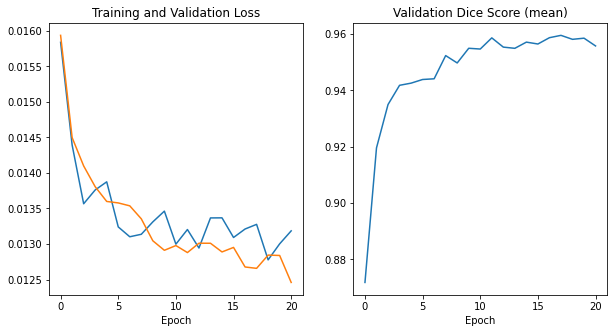

In [11]:
for fold in range(CFG.train_folds):
    model_name = f"{CFG.exp_name}_f{fold}"
    val_loss = result_dict[model_name]["val_loss"]
    val_dice = result_dict[model_name]["val_dice"]
    tr_loss = result_dict[model_name]["tr_loss"]

    fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    ax[0].plot(val_loss)
    ax[0].plot(tr_loss)
    ax[0].set_title('Training and Validation Loss')
    ax[0].set_xlabel('Epoch')

    ax[1].plot(val_dice)
    ax[1].set_title('Validation Dice Score (mean)')
    ax[1].set_xlabel('Epoch')

In [12]:
for fold in range(CFG.train_folds):
    print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")
    print(f"Fold {fold+1}")
    print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")
    model_name = f"{CFG.exp_name}_f{fold}"
    valid_dice_each_cls = result_dict[model_name]["val_dice_each_cls"]
    for cls in range(CFG.n_class):
        print(f"{organ_index_dict_inv[cls]} Dice Score : {valid_dice_each_cls[-1][cls]:.3f}")
    print()

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Fold 1
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
liver Dice Score : 0.978
spleen Dice Score : 0.939
kidney Dice Score : 0.973
bowel Dice Score : 0.934

